In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd "drive/My Drive/Colab Notebooks/ADA_P4/data"

/content/drive/My Drive/Colab Notebooks/ADA_P4/data


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [4]:
def calculate_distance (lat1,lon1,lat2,lon2):
    """
    R : radius of earth : 6378.137 km
    lat1,lon1 : latitude and longitude of one user
    lat2,lon2 : latitude and longitude of other user
    """
    R = 6378.137
    # convert into radians
    lat1_rad=np.deg2rad(lat1)
    lat2_rad=np.deg2rad(lat2)
    lon1_rad=np.deg2rad(lon1)
    lon2_rad=np.deg2rad(lon2)
    
    #get difference of lattitude and difference of longitude
    delta_lat=lat2_rad-lat1_rad
    delta_lon=lon2_rad-lon1_rad
    
    #return formula Haversine formula
    a=((np.sin(0.5*delta_lat))**2)+np.cos(lat1_rad)*np.cos(lat2_rad)*((np.sin(0.5*delta_lon))**2)
    return 2*R*np.arcsin(np.sqrt(a))

def cont (x):
    if any(x.str.contains('Home','private')):return 1
    else : return 0

## 2) Friends checkins:


- We want to find checkin patterns between friends gaherings.
- For that, we create a new dataframe, with whome we are are going to work for this whole part.
- We assume two friends have met together if they have checked in the same place with at most one hour difference. Since our dataframe is labeled and each place has its own id, we don't need to do any approximation on the checkin distance between friends.


In [5]:
def friends_gatherings(PROCEEDED_PATH,FRIENDSHIPS_PATH):
    """
    function to get dataframe where friends gathered
    INPUTS : 
    PROCEEDED_PATH : proceeded dataset path
    FRIENDSHIPS_PATH : friendships (edges) path
    OUTPUTS :
    1) dataframe that will be used for 1 futur plot, contains two columns : distance from home and probability of checkin
    This dataframe isn't limited to friends checkins and is used to see if there is any difference
    between considering friends gatherings or not
    2) Friends dataframe : contains the dataframe that will be used all this part for our studies.
    This dataframe contains the columns ['User ID','Venue ID','day','local time','lat','lon','place','country']

    In order to have a study that is the most accurate possible, we only work on users that checked in their homes at least once.
    That helps us make no approximation on the home location. 
    Moreover, our dataframe being large, we don't have the problem of not having enough data to study.

    In order to preserve memory, we will import the friendship dataframe in this function, we won't need it after that.
    """
    #Import two datasets
    df=pd.read_csv(PROCEEDED_PATH,parse_dates=['local time'])
    friendships=pd.read_csv(FRIENDSHIPS_PATH,sep='\t',encoding='latin-1',names=['User ID','User2 ID'], header=None)

    #clean edges dataframe : erase columns where the person following and the person followed is the same
    friendships=friendships[friendships['User ID']!=friendships['User2 ID']]

    print('begin getting homes')
    #create a new dataframe : df1 : used to find the home location of each user 
    #To do that,  we keep only the line where the user checked in their homes
    #Then, we get the means of checkin latitude and longitude for each user and each place checked in to find the home location
    # ==> The home location is the mean of checkins that were in the home of a user
    # We finally return only the three columns needed to perform the final merge to have the final 

    #We just initialize the two columns we need
    df1=df[['User ID','lat','lon','place']].rename(columns={'lat':'home lat','lon':'home lon'})
    df1=df1.groupby(['User ID','place'],as_index=False).\
        agg({'home lat':'mean','home lon':'mean'},axis='columns')
    df1=df1[df1['place'].str.contains('Home (private)',regex=False)][['User ID','home lat','home lon']]
    #df1 now contains for each user his home longitude and home latitude

    #We then perform a merge with the original dataset to integrate the home coordinates to the dataset
    df1=df1.merge(df[['User ID','Venue ID','day','local time','lat','lon','place','country']])
    df1['dist home']=calculate_distance(df1['lat'],df1['lon'],df1['home lat'],df1['home lon']).round()
    
    #Now we move to finding the 
    merged_friends=pd.DataFrame()
    chunksize=10**6
    numb_chunks=int(np.ceil(df1.shape[0]/chunksize))
    print('begin merging')
    #We work with chunks of size 10**6 each
    for i in range(numb_chunks):
        # Since we want the checkin place to be exactly the same for each user (have the same id),
        #we perform the merge on both the user and his checkin place (this procedure helped us save much memory and time)
        tmp_merge=df1[chunksize*i:chunksize*(i+1)].merge(friendships).\
                    merge(df1[['User ID','Venue ID','local time']],\
                          left_on=['User2 ID','Venue ID'],right_on=['User ID','Venue ID']).\
                    rename(columns={'dist home_x':'dist home'})

        #filtre the tmp_merge with friends that checked in at most with one hour difference in the same place
        tmp_merge=tmp_merge[(np.abs((tmp_merge['local time_x']-tmp_merge['local time_y']).dt.total_seconds())<3600)]
        tmp_merge=tmp_merge.rename(columns={'local time_x':'local time'})

        #append the chunk to the final dataset
        merged_friends=merged_friends.append(tmp_merge[['day','local time','place','country','dist home']],ignore_index=True)
        
        if i==int(0.5*numb_chunks):print('halfway through merging')
    print('finished merging')
    return get_vects_plot(df1[['dist home']]),merged_friends

In [6]:
def get_vects_plot(df):
    """
    function to calculate the probability of checkin as a function of the distance
    Returns a dataframe where there are two columns: the distance from home and its probiability
    """
    df['proba dist']=df['dist home']
    df=df.groupby('dist home',as_index=False).count()[['dist home','proba dist']]
    df['proba dist']=df['proba dist']/df['proba dist'].sum()
    return df[['dist home','proba dist']]

In [7]:
PROCEEDED_PATH='processed_dataset.csv'
FRIENDSHIPS_PATH='dataset_WWW_friendship_new.txt'
df_tot,df_friends=friends_gatherings(PROCEEDED_PATH,FRIENDSHIPS_PATH)

begin getting homes
begin merging
halfway through
finished merging


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
def apply_median(y,N=6):
    """
    smoth curve using median
    y : to be plotted
    N : Number of items to use to smooth curve
    We choose not to do this process for small values because the curve is already smooth for small distances
    """
    y1=np.copy(y)
    
    for i in range (N,len(y)):
        if i>N:y1[i]=np.median(y[0:i+N])
        elif i<len(y)-N : y1[i]=np.median(y[i-N:i+N])
        else : y1[i]=np.median(y[i-N:len(y)])
    
    return y1

In [9]:
from scipy.optimize import curve_fit

In [10]:
def power_func(x, a, b):
    return a * np.power( x,b)


In [11]:
df_plot_friends=get_vects_plot(df_friends)


In [12]:
change_point=19
x_log=np.logspace(0,4.05,50)

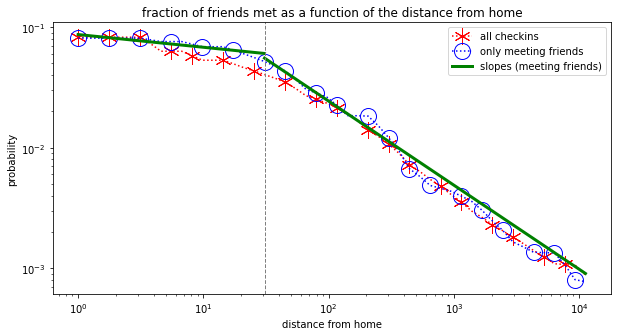

In [14]:
f_friends=interp1d(df_plot_friends['dist home'],df_plot_friends['proba dist'],kind='zero')
f_tot=interp1d(df_tot['dist home'],df_tot['proba dist'],kind='zero')

#y_friends,y_tot will be the vectors used for the plot, we aply median to smooth the curves
y_friends=apply_median(f_friends(x_log),N=1)
y_tot=apply_median(f_tot(x_log),N=1)

params_friends1,_=curve_fit(power_func,x_log[:change_point],y_friends[:change_point])
params_friends2,_=curve_fit(power_func,x_log[change_point:],y_friends[change_point:])

plt.figure(figsize=(10,5))
marker_style_all = dict(color='r', linestyle=':', marker=(6, 2, 0),markersize=16)

plt.loglog(x_log,y_tot,markevery=0.05, **marker_style_all,label='all checkins')


marker_style_friends = dict(color='blue', linestyle=':', marker='o',markersize=16,fillstyle='none')
plt.loglog(x_log,y_friends,markevery=0.05, **marker_style_friends,label='only meeting friends')
plt.xlabel('distance from home')
plt.ylabel('probability')
plt.title('fraction of friends met as a function of the distance from home')

plt.loglog(x_log[change_point-1:], power_func(x_log[change_point-1:], params_friends2[0], params_friends2[1]),\
                  color='g',linewidth=3,label='slopes (meeting friends)')
plt.loglog(x_log[:change_point], power_func(x_log[:change_point], params_friends1[0], params_friends1[1]),\
                  color='g',linewidth=3)
plt.axvline(x_log[change_point-1],linestyle='--',linewidth=1, color='grey')
#plt.xticks([change_point+1],[round(x_log[change_point-1],0)])
plt.legend()

In [19]:
print('we have slopes of {} for distances inferior to 30km and slopes of {} for distances superior to 3km'.\
      format(round(params_friends1[1],3),round(params_friends2[1],3)))

we have slopes of -0.106 for distances inferior to 30km and slopes of -0.697 for distances superior to 3km


In [20]:
print('For distances inferior to 30km, the distribution checkins knowingthe distance from home can ba approximates as :\
 P(x)={}*exp({}*x)'.format(round(params_friends1[0],3),round(params_friends1[1],3)))
print('For distances superior to 30km, the distribution checkins knowingthe distance from home can ba approximates as :\
 P(x)={}*exp({}*x)'.format(round(params_friends2[0],3),round(params_friends2[1],3)))

For distances inferior to 30km, the distribution checkins knowingthe distance from home can ba approximates as : P(x)=0.087*exp(-0.106*x)
For distances superior to 30km, the distribution checkins knowingthe distance from home can ba approximates as : P(x)=0.603*exp(-0.697*x)


- Whether a user visited a friend or not does not make much differences in the overall behavior of checkins 

- We can also approximate the probability of moving from home knowing the distance with two equations:

$$ P(x)=
\begin{cases}
    0.87e^{-0.106x} & \text{if x<30 km}\\
    0.603e^{-0.697x} & \text{otherwise}
\end{cases}
$$

- We notice a change in the slope at a distance of approximately 30km distance from home. This behavior is similar to the one described in the paper. However, some differences are noticeble:  
1) The shift happened in a distance of 30km from home (vs 100km using other daasets)  
2) The slope

In [ ]:
#number_restaurant_meetings=df[df['place_x'].str.contains('restaurant',case=False)].shape[0]
#number_bar_meetings=df[df['place_x'].str.contains('bar',case=False)].shape[0]

In [ ]:
df.shape
df1=df.copy()
df1.head()

,Unnamed: 0,day_x,local time_x,place_x,country_x,dist home x,dist home y,proba dist
0,184,Sat,2012-05-05 19:24:41+00:00,Bar,US,161.0,6.0,161.0
1,458,Fri,2012-05-04 16:45:44+00:00,Airport,US,18.0,321.0,18.0
2,628,Wed,2013-06-18 20:06:35+00:00,Ice Cream Shop,US,159.0,2590.0,159.0
3,652,Thu,2012-06-06 23:20:26+00:00,Tech Startup,US,160.0,40.0,160.0
4,690,Fri,2012-06-08 17:35:57+00:00,Tech Startup,US,160.0,40.0,160.0


### I) Preprocessing :
- We now go through our dataset and gategorize our places features into different categories:  
1) `Eat` : Going to eat with friends (restaurant , fast food ...)  
2) `Study` : Studying (being in school, universty ...)  
3) `Drink` : Having a drink with friends, going out ...  
4) `Culture` : Going to watch a movie, visit monuments ...  
5) `Home` : meet at someone's home  
6) `Move` : take public transports or travel to far places  
7) `Consume` : Visit stores, malls ...  
8) `Work` : Being in work's place  
9) `Entertain` : Go to a spa, hotel, beach,park ...  
10) `Sport` : practise sports together  

- We also categorize the days of the week into two types:  
1) `Working days` : Monday until Friday  
2) `Week end day` : Saturday and Sunday  

### II) Processing :
- We study the probability people meet in each category
- We compare normalized probabilities




In [ ]:
df1=df.copy()

df1.loc[df1['place_x'].str.contains('restaurant|Burger|pizza|Diner|food|Steakhouse|BBQ|Dessert|Ramen|Ice Cream|Fried|Sandwich|breakfast|snack|taco|hot|soup|wings',case=False),'place_x']='Eat'
df1.loc[df1['place_x'].str.contains('college|University|school|student',case=False),'place_x']='Study'
df1.loc[df1['place_x'].str.contains('coffee|Bar|Nightclub|pub|Lounge|Beer|tea|Nightlife',case=False),'place_x']='Drink'
df1.loc[df1['place_x'].str.contains('multiplex|Movie|Theater|concert|Music|historic|arts|Museum|library|Monument|temple|art',case=False),'place_x']='Culture'
df1.loc[df1['place_x'].str.contains('Home|Residential|Building',case=False),'place_x']='Home'
df1.loc[df1['place_x'].str.contains('station|airport|subway|travel|boat|bus',case=False),'place_x']='Move'
df1.loc[df1['place_x'].str.contains('store|mall|plaza|shop|boutique|market',case=False),'place_x']='Consume'
df1.loc[df1['place_x'].str.contains('work|office|Startup|professional',case=False),'place_x']='Work'
df1.loc[df1['place_x'].str.contains('soccer stadium|Entertainment|Outdoor|beach|park|event|Arcade|resort|hotel|spa|Casino',case=False),'place_x']='Entertainement'
df1.loc[df1['place_x'].str.contains('soccer field|sport|gym|stadium|surf|pool|golf|baseball',case=False),'place_x']='Sport'
#df1.loc[df1['place_x'].str.contains('Neighborhood|road|bakery|church|mosque|hospital|bank|bridge|rest',case=False),'place_x']='Others'

df1.loc[df1['day_x'].str.contains('mon|tue|wed|thu|fri',case=False),'day_x']='Work day'
df1.loc[df1['day_x'].str.contains('sat|sun',case=False),'day_x']='Week end'


df2=df1.loc[df1['place_x'].str.contains('sport|Entertainement|Work|Consume|Move|Home|Culture|Drink|Study|Eat',case=False),:]
df3=df2.groupby(['place_x','day_x'],as_index=False).agg({'country_x':'size'}).\
                sort_values(by='country_x',ascending=False)[['place_x','day_x','country_x']].\
                rename(columns={'country_x':'numb checkins'})
#df1.groupby('place_x').count().sort_values(by='day_x',ascending=False).head(50)

In [ ]:
df3.head(2)

,place_x,day_x,country_x
17,Study,Work day,41063
7,Eat,Work day,17308


(20, 3)

Text(0.5, 1.0, 'meeting patterns between friends')

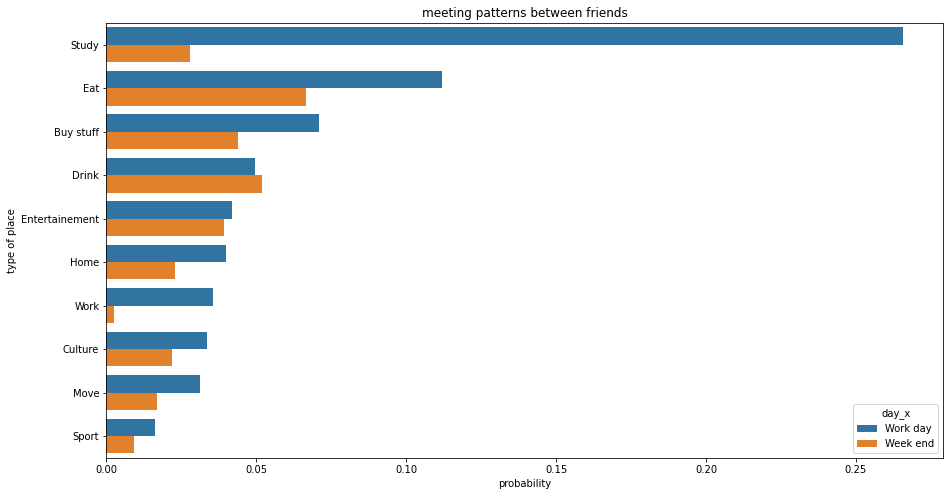

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(x=df3['country_x']/df3['country_x'].sum(),y=df3['place_x'],orient='h',hue=df3['day_x'])
plt.xlabel('probability')
plt.ylabel('type of place')
plt.title('meeting patterns between friends')

In [ ]:
def tbd2 (x):
    return sum(x)/max(x)
###### JUSTE DIFF OU DIVISER PAR TOT?????????????????????????????????

In [ ]:
df4=df3.copy()
#normalize to have proba/day
df4.loc[df4['day_x'].str.contains('Week|end',case=False),'country_x']=-df4.loc[df4['day_x'].str.contains('Week|end',case=False),'country_x']/2
df4.loc[df4['day_x'].str.contains('Work|day',case=False),'country_x']=df4.loc[df4['day_x'].str.contains('Work|day',case=False),'country_x']/5
df4=df4.groupby('place_x',as_index=False).agg({'country_x':tbd2},axis='columns').sort_values(by='country_x',ascending=False)


Text(0.5, 1.0, 'meeting patterns between friends day week vs week end')

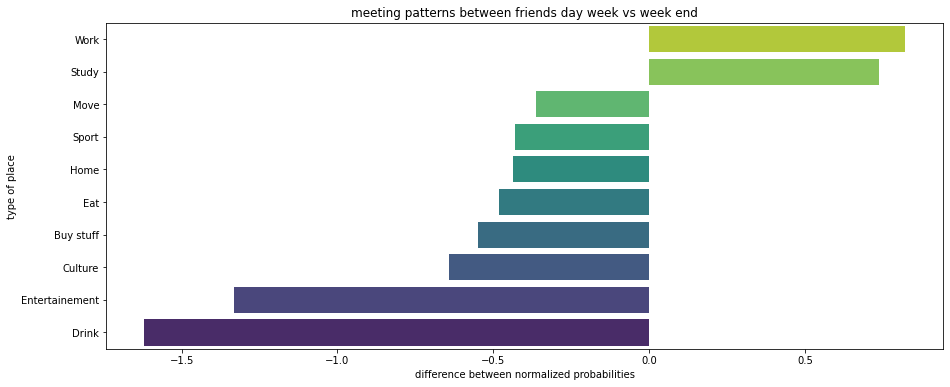

In [ ]:
plt.figure(figsize=(15,6))
sns.barplot(x=df4['country_x'],y=df4['place_x'],orient='h', palette='viridis_r')
plt.xlabel('difference between normalized probabilities')
plt.ylabel('type of place')
plt.title('meeting patterns between friends day week vs week end')

In [ ]:
df2.loc[:,'evening']=df2['local time_x'].dt.hour>18

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
df2.head()

,Unnamed: 0,day_x,local time_x,place_x,country_x,dist home x,dist home y,proba dist,evening
0,184,Week end,2012-05-05 19:24:41+00:00,Drink,US,161.0,6.0,161.0,True
1,458,Work day,2012-05-04 16:45:44+00:00,Move,US,18.0,321.0,18.0,False
2,628,Work day,2013-06-18 20:06:35+00:00,Eat,US,159.0,2590.0,159.0,True
3,652,Work day,2012-06-06 23:20:26+00:00,Culture,US,160.0,40.0,160.0,True
4,690,Work day,2012-06-08 17:35:57+00:00,Culture,US,160.0,40.0,160.0,False


In [ ]:
df5=df2.groupby('place_x',as_index=False).agg({'evening':'sum','country_x':'size'})

In [ ]:
df5['ratio evening']=df5['evening']/df5['country_x']
df5=df5.sort_values(by='ratio evening',ascending=False)

Text(0.5, 1.0, 'ratio of evening checkins')

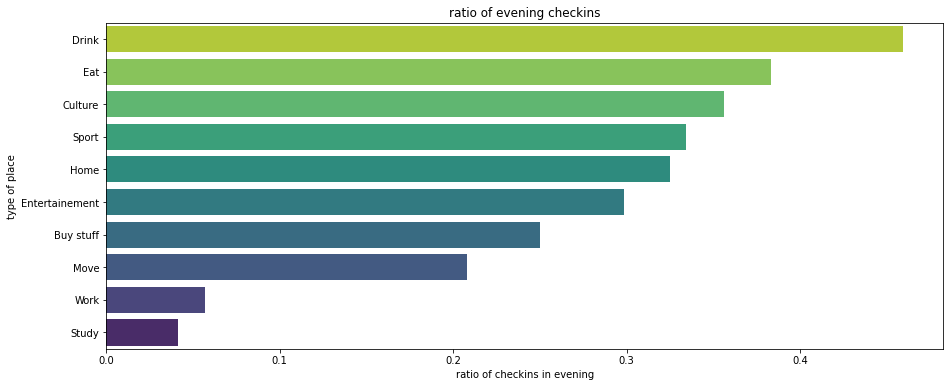

In [ ]:
plt.figure(figsize=(15,6))
sns.barplot(x=df5['ratio evening'],y=df5['place_x'],orient='h', palette='viridis_r')
plt.xlabel('ratio of checkins in evening')
plt.ylabel('type of place')
plt.title('ratio of evening checkins')

### III) Conclusions :
- People tend to meet their friends more in work or study places during the week. This can be explained by the fact that people usually have their coworkers and classmates as friends on social media. Studying or working is part of people's obligations and these are task are generally proceeded during the week
- However, when it comes to free time (week end for most of people), people choose to meet their friends in diverting places (every other category that doesn't involve working or studying). Specifically, people are the most likely to go out in weekend to have drinks or to entertainement places.
- Finally, people tend to spend their dayworking and studying, and then spend their evening and night in diverting places (eating, having drinks)

In [ ]:
######Code To be cleaned and 
###### interpertation of figures